Drawing heavily from "HalphaSB_reduce_resolution.py" to create a more functional plotting tool to plot the EAGLE simulation with the Dragonfly FOV (either on top or as the whole image).

I ended up abandoning this and moving back to a .py script (the same name)

and then I came back to develop the galaxy masking.

In [6]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u
import os
import get_halpha_SB
import HalphaSBplot_addnoise

%matplotlib inline

In [2]:
pixscale =  {'50Mpc': 0.237/1000.*(1.+0.0115), '100Mpc': 0.477/1000.*(1.+0.0235),'200Mpc': 0.928/1000.*(1.+0.047) , '500Mpc': 2.178/1000.*(1.+0.12)} ### Mpc / arcsec (comoving)
x_center = 47.5
y_center = 12.
x_angFOV = 3.*60.*60. # " 
y_angFOV = 2.*60.*60. # "  
x_FOV = {distance: pixscale[distance]*x_angFOV for distance in ['50Mpc','100Mpc','200Mpc','500Mpc']}  # cMpc
y_FOV = {distance: pixscale[distance]*y_angFOV for distance in ['50Mpc','100Mpc','200Mpc','500Mpc']}  # cMpc


In [3]:
def plotit_general(data, size, xystarts, ax1, exptime, mymap='gist_gray', res=100, label=''):
    
    data_obs = HalphaSBplot_addnoise.addnoise(data,resolution,exptime=exptime,CMOS=True)
    
    # Plot the subtracted noiseadded data
    #fig = plt.figure(figsize = (9.5, 5.))
    #ax1 = plt.subplot(111)
    
    # Plot the data nicely
    median = np.median(data_obs);
    sig = np.sqrt(median)
    
    mymax = median + 40*sig
    mymin = median - 5*sig
    
    SBdata_clipped = data_obs
    SBdata_clipped[SBdata_clipped < mymin] = mymin
    SBdata_clipped[SBdata_clipped > mymax] = mymax
    SBdata_clipped = SBdata_clipped - mymin

    get_halpha_SB.makemap(np.log10(SBdata_clipped**0.5),size,ax1,xystarts=xystarts,colmap=mymap,label=label,colorbar=False)


In [4]:
machine='coho'

In [7]:
# load the data:
fnames_100 = {'50Mpc':'data_50Mpc_100arcsec.npz','100Mpc':'data_100Mpc_100arcsec.npz','200Mpc':'data_200Mpc_100arcsec.npz','500Mpc':'data_500Mpc_100arcsec.npz'}  ## two level dictionary when want different resolutions?
resolution=100. #arcsec
# prep data locations
data_tuple_array = []
        
for distance,ind in zip(['50Mpc','100Mpc','200Mpc','500Mpc'],[0,1,2,3]):
    fname = fnames_100[distance]

    if os.path.isfile(fname):
        print("data tuple exists, loading %s now..."%fname)
        data_tuple_array.append(np.load(fname)['arr_0'])
    else:
        print("data not saved, loading from total res, 5Mpc slice, file now...")
        fname = 'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5_total.npz'
        if os.path.isfile(fname):
            print("data exists, loading %s now..."%fname)
             sl = [slice(None,None,None), slice(None,None,None)]
             data = (np.load(fname)['arr_0'])[sl]
        else:
            print("data not saved, loading from original files now...")
            data = loaddata()
            np.savez(fname,data)
                    
        data_tuple = changeres(distance,100,data)
        data_tuple_array.append(data_tuple)
        np.savez(fname,data_tuple)
                
data_50_100_tuple=data_tuple_array[0]; data_100_100_tuple=data_tuple_array[1]; 
data_200_100_tuple=data_tuple_array[2]; data_500_100_tuple=data_tuple_array[3];
        
data_dict = {'50Mpc':data_50_100_tuple,'100Mpc':data_100_100_tuple,'200Mpc':data_200_100_tuple,'500Mpc':data_500_100_tuple}


data tuple exists, loading data_50Mpc_100arcsec.npz now...
data tuple exists, loading data_100Mpc_100arcsec.npz now...
data tuple exists, loading data_200Mpc_100arcsec.npz now...
data tuple exists, loading data_500Mpc_100arcsec.npz now...


In [11]:
def plot1():
    """
    Only four plots at different distances, either all raw EAGLE or all mock obs
    Return the FOV data
    """
    # plot them all together
    #f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (11.5, 10.))
    mockobs=False
    f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize = (15.5, 15.))
    
    data_FOV_array = []
    for distance,axis in zip(['50Mpc','100Mpc','200Mpc','500Mpc'],[ax1,ax2,ax3,ax4]):
        data_tuple = data_dict[distance]
        factor = data_tuple[2]; newsize = data_tuple[1]; data = data_tuple[0]; resolution = 100.
            
        xystarts = [x_center-x_FOV[distance]/2.,y_center-y_FOV[distance]/2.]
        size     = [x_FOV[distance], y_FOV[distance]]
            
        x1 = ((x_center-x_FOV[distance]/2.)/100.*(newsize/factor))
        x2 = ((x_center+x_FOV[distance]/2.)/100.*(newsize/factor))
        y1 = ((y_center-y_FOV[distance]/2.)/100.*(newsize/factor))
        y2 = ((y_center+y_FOV[distance]/2.)/100.*(newsize/factor))
        data_FOV = data[int(x1):int(x2),int(y1):int(y2)]
        data_FOV_array.append(data_FOV)
        if mockobs:
            label = 'Mock observation at '+distance; exptime=10**7*3600.; map='bone'
            plotit_general(data_FOV,size,xystarts,axis,float(exptime), map, float(resolution), label = label)
        else:
            get_halpha_SB.makemap(data_FOV,size,axis,xystarts = xystarts)

    data_50_100_FOV=data_FOV_array[0]; data_100_100_FOV=data_FOV_array[1]; 
    data_200_100_FOV=data_FOV_array[2]; data_500_100_FOV=data_FOV_array[3]

    return data_50_100_FOV,data_100_100_FOV,data_200_100_FOV,data_500_100_FOV

The type of size is <type 'list'>
The type of size is <type 'list'>
The type of size is <type 'list'>
The type of size is <type 'list'>


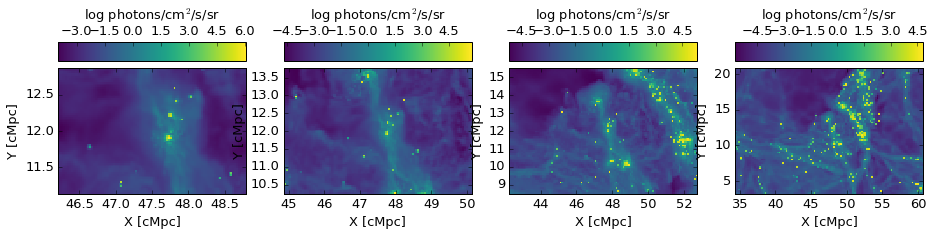

In [12]:
data_50_100_FOV,data_100_100_FOV,data_200_100_FOV,data_500_100_FOV=plot1()

In [243]:
import eagleSqlTools as sql

def searchgals(xmin,xmax,ymin,ymax,zmin,zmax):
    
    mySim = ('RefL0100N1504',100.)
    con   = sql.connect("dlokhorst",password="mxdPB54Y")  

    myQuery  = "SELECT \
                SH.GalaxyID, \
                SH.StarFormationRate as SFR, \
                SH.CentreOfPotential_x, \
                SH.CentreOfPotential_y, \
                SH.CentreOfPotential_z, \
                SH.SubGroupNumber, \
                SH.MassType_Star, \
                SH.HalfMassProjRad_Gas, \
                SH.HalfMassProjRad_Star \
            FROM \
                %s_SubHalo as SH \
            WHERE \
                SH.SnapNum = 28 and \
                SH.CentreOfPotential_x >= %s and \
                SH.CentreOfPotential_x <= %s and \
                SH.CentreOfPotential_y >= %s and \
                SH.CentreOfPotential_y <= %s and \
                SH.CentreOfPotential_z >= %s and \
                SH.CentreOfPotential_z <= %s and \
                SH.MassType_Star > 0 "%('RefL0100N1504',xmin,xmax,ymin,ymax,zmin,zmax)
 

                #  and \
              #  SH.StarFormationRate > 0.00001 

    if verbose:
        print myQuery
    
    myData = sql.execute_query(con,myQuery)

    xgal = myData['CentreOfPotential_x'][:]   # cMpc
    ygal = myData['CentreOfPotential_y'][:]   # cMpc
    #z = myData['CentreOfMass_z'][:]
    mgal = myData['MassType_Star'][:]         # M_solar
    rhgas = myData['HalfMassProjRad_Gas'][:]  # pkpc
    rhstar= myData['HalfMassProjRad_Star'][:] # pkpc
    
    return xgal,ygal,mgal,rhgas,rhstar

In [27]:
def getgalaxies(distance):

    xmin = x_center-x_FOV[distance]/2.
    ymin = y_center-y_FOV[distance]/2.
    xmax = x_center+x_FOV[distance]/2.
    ymax = y_center+y_FOV[distance]/2.
    print xmin,xmax,ymin,ymax
        
    zmin = 10.; zmax = 15.  # using the mid z 12.5 sims
    
    return searchgals(xmin,xmax,ymin,ymax,zmin,zmax)

46.2054823 48.7945177 11.1369882 12.8630118
SELECT                 SH.GalaxyID,                 SH.StarFormationRate as SFR,                 SH.CentreOfPotential_x,                 SH.CentreOfPotential_y,                 SH.CentreOfPotential_z,                 SH.SubGroupNumber,                 SH.MassType_Star,                 SH.HalfMassProjRad_Gas,                 SH.HalfMassProjRad_Star             FROM                 RefL0100N1504_SubHalo as SH             WHERE                 SH.SnapNum = 28 and                 SH.CentreOfPotential_x >= 46.2054823 and                 SH.CentreOfPotential_x <= 48.7945177 and                 SH.CentreOfPotential_y >= 11.1369882 and                 SH.CentreOfPotential_y <= 12.8630118 and                 SH.CentreOfPotential_z >= 10.0 and                 SH.CentreOfPotential_z <= 15.0 and                 SH.MassType_Star > 0 and                 SH.StarFormationRate > 0.00001 


(array([ 3.,  1.,  0.,  1.,  1.,  1.,  3.,  1.,  1.,  1.]),
 array([  6.2171216 ,   6.60405717,   6.99099274,   7.3779283 ,
          7.76486387,   8.15179944,   8.53873501,   8.92567058,
          9.31260614,   9.69954171,  10.08647728]),
 <a list of 10 Patch objects>)

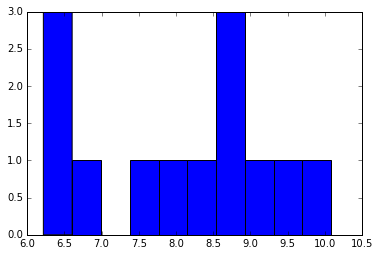

In [68]:
distance = '50Mpc'
xgal,ygal,mgal,rhgas,rhstar = getgalaxies(distance)
plt.hist(np.log10(mgal))

In [92]:
rhgas
data_50_100_FOV.shape

(103, 69)

In [214]:
def plotgals(xgal,ygal,rhgas,rhstar,ax1):
    for i in range(len(xgal)):
        circle1 = plt.Circle((xgal[i],ygal[i]), radius=rhgas[i]/1000., color='red',fill=False)
        ax1.add_artist(circle1)
        circle1 = plt.Circle((xgal[i],ygal[i]), radius=rhstar[i]/1000., color='blue',fill=False)
        ax1.add_artist(circle1)
        if verbose:
            print('%s and %s and the radius of stars is %s '%(xgal[i],ygal[i],rhstar[i]))
        
def maskgals(xgal,ygal,rhgas,data,xystarts,size):
    xsize = data.shape[0]
    ysize = data.shape[1]
    xlen  = size[0]
    ylen  = size[1]

    data_masked = np.array([[i for i in line] for line in data])
    for i in range(len(xgal)):
        xind = (xgal[i]-xystarts[0])*xsize/xlen
        yind = (ygal[i]-xystarts[1])*ysize/ylen
        if rhgas[i] > (pixscale[distance]*100.*1000.):  # if the gas scale length is greater than the pixel size
            print("rhgas, %s, is greater than %s kpc"%(rhgas[i],round(pixscale[distance]*100.*1000.)))
            xind = int(round(xind))
            yind = int(round(yind))
            if xind+2<data.shape[0] and yind+2<data.shape[1]:
                data_sub = np.mean([data[xind+2,yind+2],data[xind-2,yind-2],data[xind-2,yind+2],data[xind+2,yind-2]])
            elif xind+2<data.shape[0]:
                data_sub = np.mean([data[xind-2,yind-2],data[xind-2,yind],data[xind+2,yind-2]])
            elif yind+2<data.shape[0]:
                data_sub = np.mean([data[xind-2,yind-2],data[xind-2,yind+2],data[xind,yind-2]])
            data_sub = -3
            data_masked[xind,yind]=data_sub
            # mask the pixels around the central pixel
            data_masked[xind+1,yind]=data_sub
            data_masked[xind-1,yind]=data_sub
            data_masked[xind,yind+1]=data_sub
            data_masked[xind,yind-1]=data_sub
            data_masked[xind+1,yind+1]=data_sub
            data_masked[xind-1,yind-1]=data_sub
            data_masked[xind+1,yind-1]=data_sub
            data_masked[xind-1,yind+1]=data_sub
        else:
            xind = int(round(xind))
            yind = int(round(yind))
            #print(xind,yind)
            
            
            # check to make sure not in a corner
            if yind+1 <data.shape[1] and yind>0 and xind+1<data.shape[0] and xind>0:
                data_sub = np.mean([data[xind,yind-1],data[xind+1,yind-1]])
                data_sub = -3
                data_masked[xind,yind] = data_sub
            else:
                print("in a corner and i cant stand it")
            #elif yind>=data.shape[1]:
            #    yind = data.shape[1]-1
            #elif :
            #    data_sub = np.mean([data[xind-1,yind],data[xind,yind-1]])
            
    return data_masked

The type of size is <type 'list'>
46.2054823 48.7945177 11.1369882 12.8630118
For the distance of 50Mpc, each pixel is 23.97255 kpc a side
rhgas, 37.8563, is greater than 24.0 kpc
rhgas, 54.7057, is greater than 24.0 kpc
rhgas, 47.0905, is greater than 24.0 kpc
The type of size is <type 'list'>
The type of size is <type 'list'>


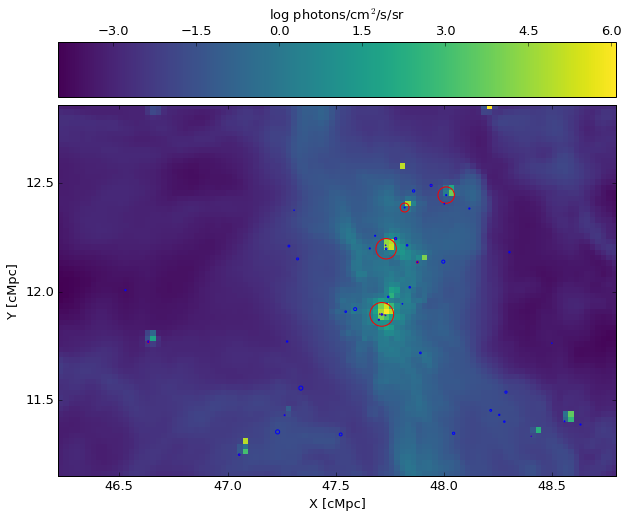

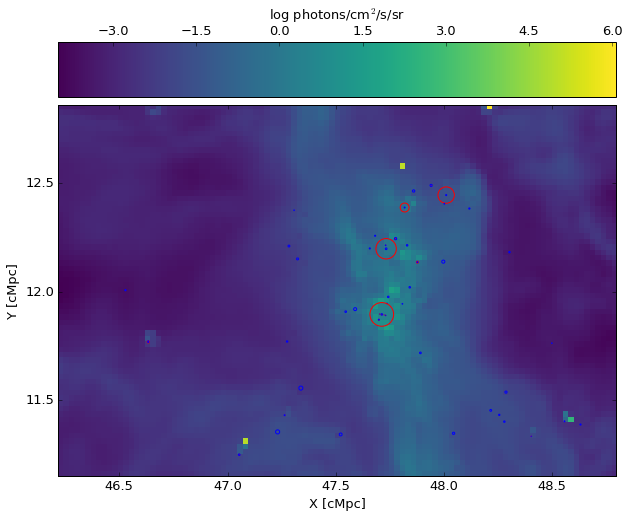

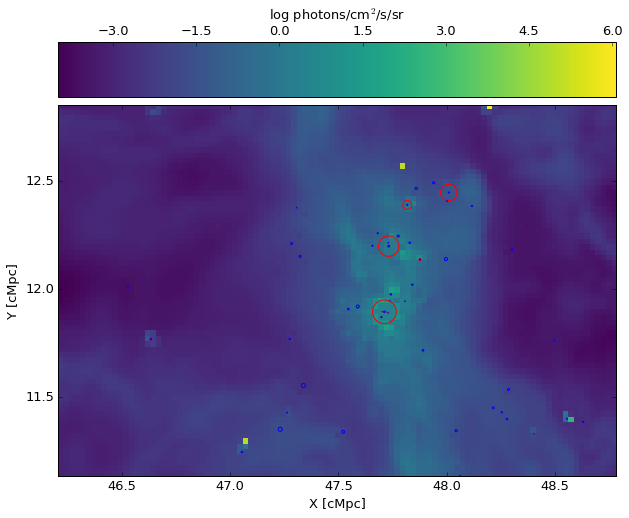

In [247]:
verbose=False; distance='50Mpc'
xystarts = [x_center-x_FOV[distance]/2.+pixscale[distance]*100./2.,y_center-y_FOV[distance]/2.+pixscale[distance]*100./2.]
size     = [x_FOV[distance]-pixscale[distance]*100./2., y_FOV[distance]-pixscale[distance]*100./2.]
fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_50_100_FOV,size,axis,xystarts = xystarts)

xgal,ygal,mgal,rhgas,rhstar = getgalaxies(distance)
plotgals(xgal,ygal,rhgas,rhstar,axis)
print("For the distance of %s, each pixel is %s kpc a side"%(distance,pixscale[distance]*100.*1000.))


data_masked = maskgals2(xgal,ygal,rhgas,data_50_100_FOV,xystarts,size)

fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_masked,size,axis,xystarts = xystarts)
plotgals(xgal,ygal,rhgas,rhstar,axis)

xystarts = [x_center-x_FOV[distance]/2.,y_center-y_FOV[distance]/2.]
fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_masked,size,axis,xystarts = xystarts)
plotgals(xgal,ygal,rhgas,rhstar,axis)


The type of size is <type 'list'>
For the distance of 100Mpc, each pixel is 48.82095 kpc a side
44.8636687 50.1363313 10.2424458 13.7575542
rhgas, 130.529, is greater than 49.0 kpc
rhgas, 54.7057, is greater than 49.0 kpc
rhgas, 96.1215, is greater than 49.0 kpc
The type of size is <type 'list'>
The type of size is <type 'list'>


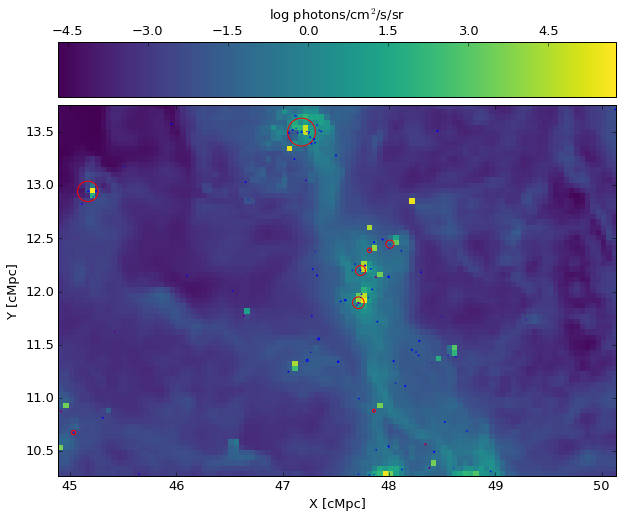

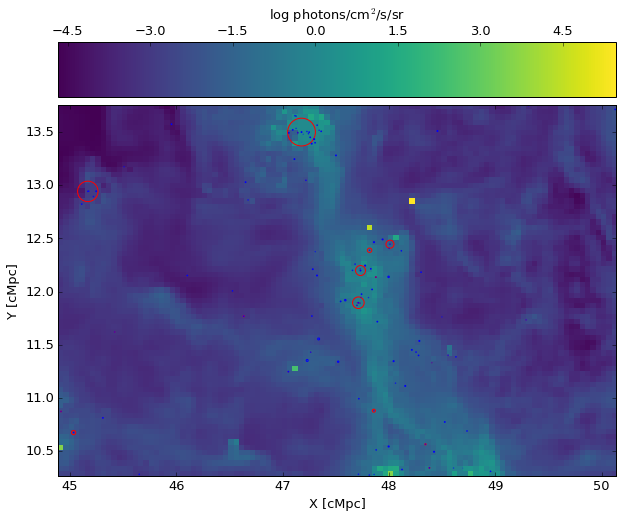

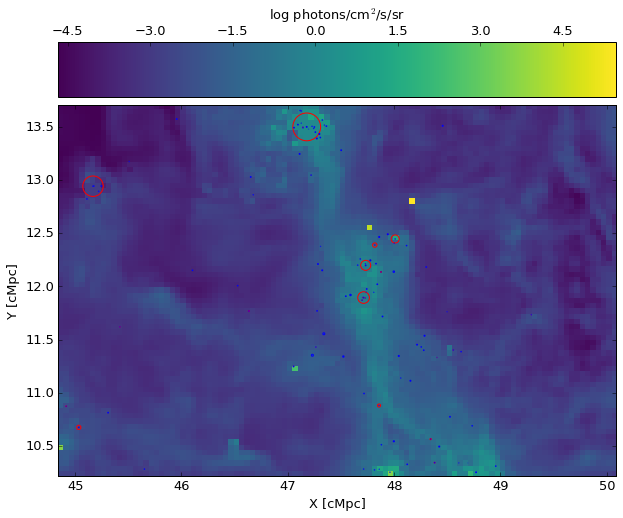

In [248]:
distance='100Mpc'
xystarts = [x_center-x_FOV[distance]/2.+pixscale[distance]*100./2.,y_center-y_FOV[distance]/2.+pixscale[distance]*100./2.]
size     = [x_FOV[distance]-pixscale[distance]*100./2., y_FOV[distance]-pixscale[distance]*100./2.]
#size     = [x_FOV[distance], y_FOV[distance]]
fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_100_100_FOV,size,axis,xystarts = xystarts)

print("For the distance of %s, each pixel is %s kpc a side"%(distance,pixscale[distance]*100.*1000.))

# load the galaxy catalogue
xgal,ygal,mgal,rhgas,rhstar = getgalaxies(distance)
# plot the galaxy locations
plotgals(xgal,ygal,rhgas,rhstar,axis)
# mask the galaxies in the EAGLE data
data_masked = maskgals2(xgal,ygal,rhgas,data_100_100_FOV,xystarts,size)

fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_masked,size,axis,xystarts = xystarts)
plotgals(xgal,ygal,rhgas,rhstar,axis)

xystarts = [x_center-x_FOV[distance]/2.-pixscale[distance]*100./2.,y_center-y_FOV[distance]/2.-pixscale[distance]*100./2.]
fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_masked,size,axis,xystarts = xystarts)
plotgals(xgal,ygal,rhgas,rhstar,axis)

The type of size is <type 'list'>
For the distance of 200Mpc, each pixel is 97.1616 kpc a side
42.2532736 52.7467264 8.5021824 15.4978176
rhgas, 116.478, is greater than 97.0 kpc
rhgas, 130.529, is greater than 97.0 kpc
rhgas, 110.19, is greater than 97.0 kpc
rhgas, 308.327, is greater than 97.0 kpc
rhgas, 172.427, is greater than 97.0 kpc
The type of size is <type 'list'>


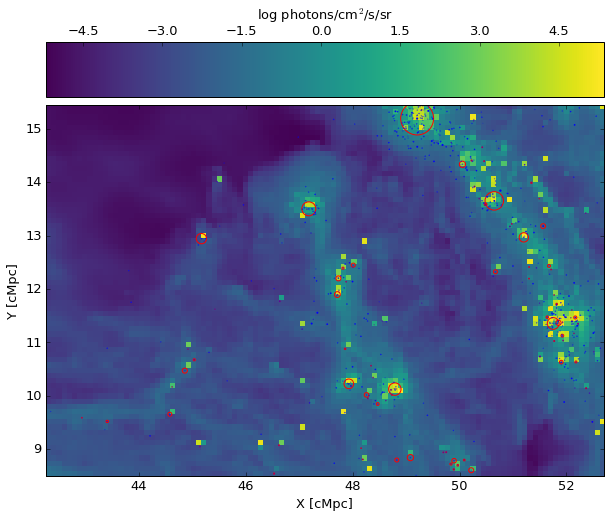

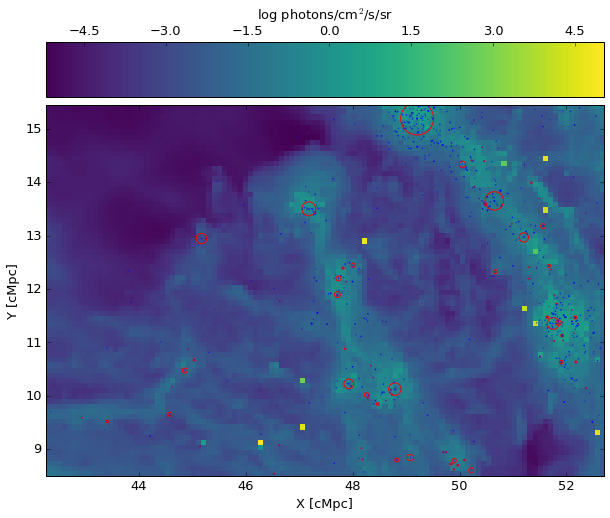

In [246]:
distance='200Mpc'
#xystarts = [x_center-x_FOV[distance]/2.+pixscale[distance]*100./2.,y_center-y_FOV[distance]/2.+pixscale[distance]*100./2.]
#xystarts = [x_center-x_FOV[distance]/2.-pixscale[distance]*100./2.,y_center-y_FOV[distance]/2.-pixscale[distance]*100./2.]
xystarts = [x_center-x_FOV[distance]/2.,y_center-y_FOV[distance]/2.]
size     = [x_FOV[distance]-pixscale[distance]*100./2., y_FOV[distance]-pixscale[distance]*100./2.]
#size     = [x_FOV[distance], y_FOV[distance]]
fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_200_100_FOV,size,axis,xystarts = xystarts)

print("For the distance of %s, each pixel is %s kpc a side"%(distance,pixscale[distance]*100.*1000.))

# load the galaxy catalogue
xgal,ygal,mgal,rhgas,rhstar = getgalaxies(distance)
# plot the galaxy locations
plotgals(xgal,ygal,rhgas,rhstar,axis)

#distance='200Mpc'
#xystarts = [x_center-x_FOV[distance]/2.+pixscale[distance]*100./2.,y_center-y_FOV[distance]/2.+pixscale[distance]*100./2.]
#xystarts = [x_center-x_FOV[distance]/2.-pixscale[distance]*100./2.,y_center-y_FOV[distance]/2.-pixscale[distance]*100./2.]
#size     = [x_FOV[distance]-pixscale[distance]*100./2, y_FOV[distance]-pixscale[distance]*100./2.]
#size     = [x_FOV[distance], y_FOV[distance]]
#fig = plt.figure(figsize=[10,10])
#axis = plt.subplot(111)
#get_halpha_SB.makemap(data_200_100_FOV,size,axis,xystarts = xystarts)

#print("For the distance of %s, each pixel is %s kpc a side"%(distance,pixscale[distance]*100.*1000.))

# load the galaxy catalogue
#xgal,ygal,mgal,rhgas,rhstar = getgalaxies(distance)
# plot the galaxy locations
#plotgals(xgal,ygal,rhgas,rhstar,axis)

# mask the galaxies in the EAGLE data
data_masked = maskgals2(xgal,ygal,rhgas,data_200_100_FOV,xystarts,size)

fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_masked,size,axis,xystarts = xystarts)
plotgals(xgal,ygal,rhgas,rhstar,axis)

In [232]:
data_masked.shape

(108, 72)

In [245]:
def maskgals2(xgal,ygal,rhgas,data,xystarts,size):
    xsize = data.shape[0]
    ysize = data.shape[1]
    xlen  = size[0]
    ylen  = size[1]

    data_masked = np.array([[i for i in line] for line in data])
    for i in range(len(xgal)):
        xind = (xgal[i]-xystarts[0])*xsize/xlen
        yind = (ygal[i]-xystarts[1])*ysize/ylen
        if rhgas[i] > (pixscale[distance]*100.*1000.):  # if the gas scale length is greater than the pixel size
            print("rhgas, %s, is greater than %s kpc"%(rhgas[i],round(pixscale[distance]*100.*1000.)))
            xind = int(round(xind))
            yind = int(round(yind))
            if xind+2<data.shape[0] and yind+2<data.shape[1]:
                data_sub = np.mean([data[xind+2,yind+2],data[xind-2,yind-2],data[xind-2,yind+2],data[xind+2,yind-2]])
            elif xind+2<data.shape[0]:
                data_sub = np.mean([data[xind-2,yind-2],data[xind-2,yind],data[xind+2,yind-2]])
            elif yind+2<data.shape[0]:
                data_sub = np.mean([data[xind-2,yind-2],data[xind-2,yind+2],data[xind,yind-2]])
            # data_sub = -3
            data_masked[xind,yind]=data_sub
            # mask the pixels around the central pixel
            data_masked[xind+1,yind]=data_sub
            data_masked[xind-1,yind]=data_sub
            data_masked[xind,yind+1]=data_sub
            data_masked[xind,yind-1]=data_sub
            data_masked[xind+1,yind+1]=data_sub
            data_masked[xind-1,yind-1]=data_sub
            data_masked[xind+1,yind-1]=data_sub
            data_masked[xind-1,yind+1]=data_sub
        else:
            xind = int(round(xind))
            yind = int(round(yind))
           # print(xind,yind)
            
            # move it out of the corner if it is in the corner
            if yind > data.shape[1]-2:
                yind = data.shape[1]-2
                #print('the new yind is %s'%yind)
            if xind > data.shape[0]-2:
                xind = data.shape[0]-2
                #print('the new xind is %s'%xind)
            if yind<1:
                yind=1
                #print('the new yind is %s'%yind)
            if xind<1:
                xind=1
                #print('the new xind is %s'%xind)
                
            # now check for the highest number around
            start=-100; maxx=0; maxy=0; tomedian=[]
            for x in [xind-1,xind,xind+1]:
                for y in [yind-1,yind,yind+1]:
                    if data_masked[x,y]>start:
                        start = data_masked[x,y]
                        maxx=x
                        maxy=y
                    tomedian.append(data_masked[x,y])
                    
            data_sub = np.median(tomedian)
            data_masked[maxx,maxy]=data_sub
            
    return data_masked

In [231]:
data_200_100_FOV.shape
data_masked = np.array([[i for i in line] for line in data_200_100_FOV])
data_masked.shape

(108, 72)

The type of size is <type 'list'>
For the distance of 500Mpc, each pixel is 243.936 kpc a side
34.327456 60.672544 3.218304 20.781696
rhgas, 308.327, is greater than 244.0 kpc
rhgas, 326.289, is greater than 244.0 kpc
The type of size is <type 'list'>


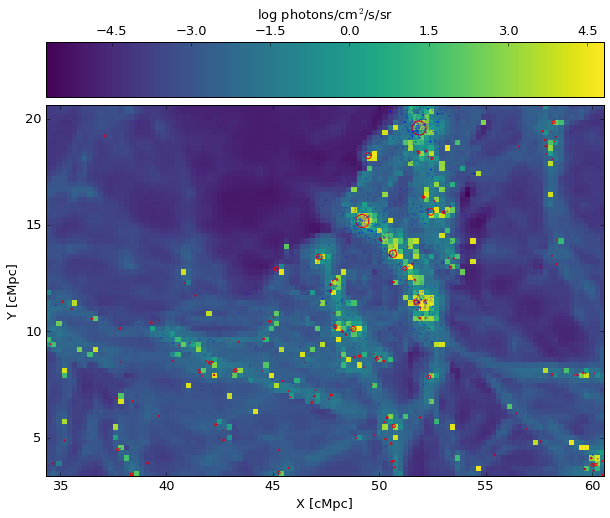

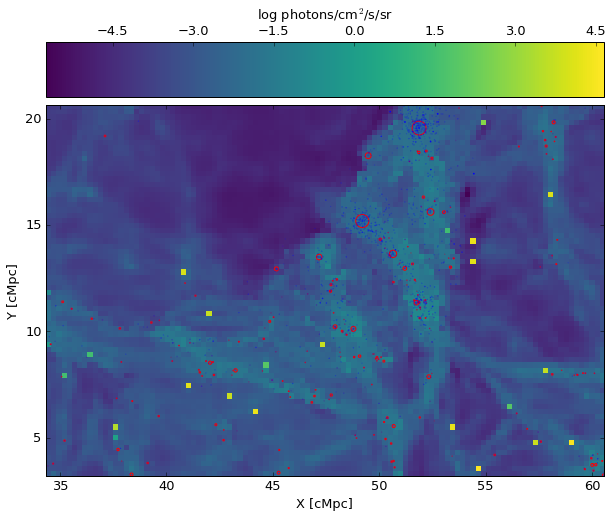

In [249]:
distance='500Mpc'
#xystarts = [x_center-x_FOV[distance]/2.+pixscale[distance]*100./2.,y_center-y_FOV[distance]/2.+pixscale[distance]*100./2.]
#xystarts = [x_center-x_FOV[distance]/2.-pixscale[distance]*100./2.,y_center-y_FOV[distance]/2.-pixscale[distance]*100./2.]
xystarts = [x_center-x_FOV[distance]/2.,y_center-y_FOV[distance]/2.]
size     = [x_FOV[distance]-pixscale[distance]*100./2., y_FOV[distance]-pixscale[distance]*100./2.]
#size     = [x_FOV[distance], y_FOV[distance]]
fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_500_100_FOV,size,axis,xystarts = xystarts)

print("For the distance of %s, each pixel is %s kpc a side"%(distance,pixscale[distance]*100.*1000.))

# load the galaxy catalogue
xgal,ygal,mgal,,rhgas,rhstar = getgalaxies(distance)
# plot the galaxy locations
plotgals(xgal,ygal,rhgas,rhstar,axis)

# mask the galaxies in the EAGLE data
data_masked = maskgals2(xgal,ygal,rhgas,data_500_100_FOV,xystarts,size)

fig = plt.figure(figsize=[10,10])
axis = plt.subplot(111)
get_halpha_SB.makemap(data_masked,size,axis,xystarts = xystarts)
plotgals(xgal,ygal,rhgas,rhstar,axis)